In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from collections import deque
from sklearn.model_selection import train_test_split
from datetime import datetime

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "binance_BTCUSDT_day.csv"

# df = pd.read_csv(csv_path, parse_dates=['timestamp'])
# df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# df = df.sort_values('Date')
# old_df = df.copy()
# df = df[:-2]

In [6]:
from yahoo_fin import stock_info as si
df = si.get_data('BTC-USD')
df['date'] = df.index
old_df = df.copy()
df = df[:-1]

sp500 = si.get_data('^GSPC')
sp500.columns = ['open_sp500', 'high_sp500', 'low_sp500', 'close_sp500', 'adjclose_sp500', 'volume_sp500', 'ticker']
sp500['date'] = sp500.index

gc = si.get_data('GC=F')
gc.columns = ['open_gc', 'high_gc', 'low_gc', 'close_gc', 'adjclose_gc', 'volume_gc', 'ticker']
gc['date'] = gc.index

dxy = si.get_data('DX-Y.NYB')
dxy.columns = ['open_dxy', 'high_dxy', 'low_dxy', 'close_dxy', 'adjclose_dxy', 'volume_dxy', 'ticker']
dxy['date'] = dxy.index

df = df.merge(sp500[['open_sp500', 'high_sp500', 'low_sp500', 'close_sp500', 'adjclose_sp500', 'volume_sp500', 'date']], on='date', how = 'left', copy = False)
df = df.merge(gc[['open_gc', 'high_gc', 'low_gc', 'close_gc', 'adjclose_gc', 'volume_gc', 'date']], on='date', how = 'left', copy = False)
df = df.merge(dxy[['open_dxy', 'high_dxy', 'low_dxy', 'close_dxy', 'adjclose_dxy', 'volume_dxy', 'date']], on='date', how = 'left', copy = False)
df.index = df['date']
df.tail()
old_df = df.copy()
df = df[:-1]

In [7]:
dxy.tail(10)

,open_dxy,high_dxy,low_dxy,close_dxy,adjclose_dxy,volume_dxy,ticker,date
2021-02-09,90.910004,90.930000,90.430000,90.440002,90.440002,0.0,DX-Y.NYB,2021-02-09
2021-02-10,90.489998,90.529999,90.250000,90.370003,90.370003,0.0,DX-Y.NYB,2021-02-10
2021-02-11,90.459999,90.470001,90.260002,90.419998,90.419998,0.0,DX-Y.NYB,2021-02-11
2021-02-12,90.410004,90.739998,90.379997,90.480003,90.480003,0.0,DX-Y.NYB,2021-02-12
2021-02-14,NaN,NaN,NaN,NaN,NaN,NaN,DX-Y.NYB,2021-02-14
2021-02-16,90.290001,90.639999,90.120003,90.510002,90.510002,0.0,DX-Y.NYB,2021-02-16
2021-02-17,90.709999,91.059998,90.620003,90.949997,90.949997,0.0,DX-Y.NYB,2021-02-17
2021-02-18,90.900002,90.980003,90.540001,90.589996,90.589996,0.0,DX-Y.NYB,2021-02-18
2021-02-19,90.570000,90.650002,90.180000,90.360001,90.360001,0.0,DX-Y.NYB,2021-02-19
2021-02-21,90.339996,90.653000,90.177002,90.339996,90.339996,0.0,DX-Y.NYB,2021-02-21


In [8]:
df.tail()

,open,high,low,close,adjclose,volume,ticker,date,open_sp500,high_sp500,...,low_gc,close_gc,adjclose_gc,volume_gc,open_dxy,high_dxy,low_dxy,close_dxy,adjclose_dxy,volume_dxy
date,,,,,,,,,,,,,,,,,,,,,
2021-02-15,48696.535156,48875.570312,46347.476562,47945.058594,47945.058594,7.706990e+10,BTC-USD,2021-02-15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-16,47944.457031,50341.101562,47201.304688,49199.871094,49199.871094,7.704958e+10,BTC-USD,2021-02-16,3939.610107,3950.429932,...,1787.300049,1797.199951,1797.199951,1141.0,90.290001,90.639999,90.120003,90.510002,90.510002,0.0
2021-02-17,49207.277344,52533.914062,49072.378906,52149.007812,52149.007812,8.082055e+10,BTC-USD,2021-02-17,3918.500000,3933.610107,...,1768.800049,1771.099976,1771.099976,614.0,90.709999,91.059998,90.620003,90.949997,90.949997,0.0
2021-02-18,52140.972656,52474.105469,51015.765625,51679.796875,51679.796875,5.205472e+10,BTC-USD,2021-02-18,3915.860107,3921.979980,...,1766.000000,1773.400024,1773.400024,587.0,90.900002,90.980003,90.540001,90.589996,90.589996,0.0
2021-02-19,51675.980469,56113.652344,50937.277344,55888.132812,55888.132812,6.349550e+10,BTC-USD,2021-02-19,3921.159912,3930.409912,...,1764.300049,1775.800049,1775.800049,587.0,90.570000,90.650002,90.180000,90.360001,90.360001,0.0


Text(0, 0.5, 'Close Price (USD)')

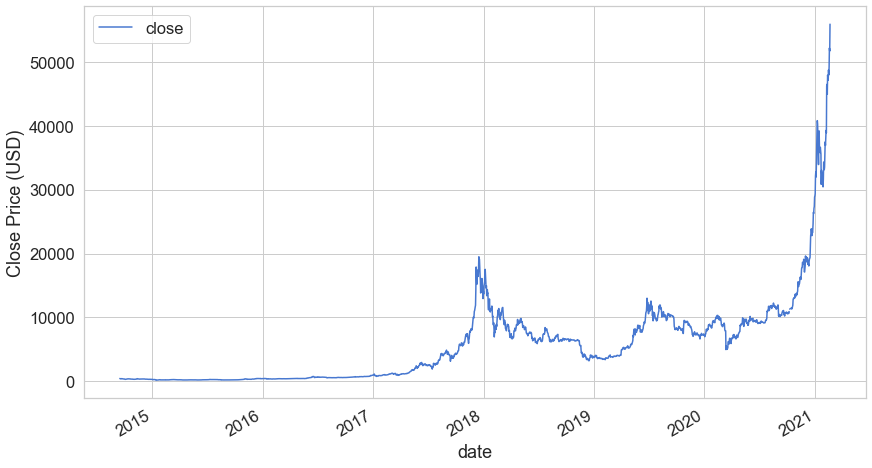

In [9]:
ax = df.plot(x='date', y='close')
ax.set_xlabel("date")
ax.set_ylabel("Close Price (USD)")

In [10]:
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'open_sp500', 'high_sp500', 'low_sp500', 'close_sp500', 'adjclose_sp500', 'volume_sp500', 'open_gc', 'high_gc', 'low_gc', 'close_gc', 'adjclose_gc', 'volume_gc']

result = {}
result['df'] = df.copy()
df_scaled = df.copy()
column_scaler = {}

# scale the data (prices) from 0 to 1
for column in feature_columns:
    scaler = MinMaxScaler()
    df_scaled[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
    column_scaler[column] = scaler

# add the MinMaxScaler instances to the result returned
result["column_scaler"] = column_scaler

# add the scaled data to the result returned
result['df_scaled'] = df_scaled

In [11]:
LOOKUP = 1

df_scaled['future_close'] = df_scaled['close'].shift(-LOOKUP)
last_sequence = np.array(df_scaled[feature_columns].tail(LOOKUP))
df_scaled = df_scaled.dropna()

In [12]:
df_scaled

,open,high,low,close,adjclose,volume,ticker,date,open_sp500,high_sp500,...,close_gc,adjclose_gc,volume_gc,open_dxy,high_dxy,low_dxy,close_dxy,adjclose_dxy,volume_dxy,future_close
date,,,,,,,,,,,,,,,,,,,,,
2014-09-16,0.005561,0.004587,0.005525,0.005012,457.334015,0.000123,BTC-USD,2014-09-16,0.070520,0.073822,...,0.184271,0.184271,0.000008,84.239998,84.370003,83.860001,84.070000,84.070000,0.0,0.004422
2014-09-17,0.005388,0.004385,0.004752,0.004422,424.440002,0.000232,BTC-USD,2014-09-17,0.078767,0.077844,...,0.183472,0.183472,0.000026,84.099998,84.709999,83.940002,84.699997,84.699997,0.0,0.003890
2014-09-18,0.004757,0.003866,0.004190,0.003890,394.795990,0.000260,BTC-USD,2014-09-18,0.080557,0.078605,...,0.174778,0.174778,0.000013,84.739998,84.739998,84.220001,84.320000,84.320000,0.0,0.004143
2014-09-19,0.004191,0.003785,0.004295,0.004143,408.903992,0.000251,BTC-USD,2014-09-19,0.085148,0.081895,...,0.164385,0.164385,0.000010,84.279999,84.800003,84.230003,84.800003,84.800003,0.0,0.003962
2014-09-22,0.004334,0.004111,0.004419,0.004626,435.790985,0.000318,BTC-USD,2014-09-22,0.083410,0.077055,...,0.165884,0.165884,0.000018,84.809998,84.860001,84.519997,84.669998,84.669998,0.0,0.004400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,0.860629,0.863150,0.865707,0.856780,47909.332031,0.659962,BTC-USD,2021-02-11,0.988980,0.988381,...,0.773559,0.773559,0.001558,90.459999,90.470001,90.260002,90.419998,90.419998,0.0,0.849519
2021-02-12,0.917945,0.868199,0.909709,0.849519,47504.851562,0.620763,BTC-USD,2021-02-12,0.986725,0.993725,...,0.770261,0.770261,0.000670,90.410004,90.739998,90.379997,90.480003,90.480003,0.0,0.842351
2021-02-16,0.919242,0.896738,0.924978,0.879945,49199.871094,0.624773,BTC-USD,2021-02-16,1.000000,1.000000,...,0.745878,0.745878,0.002953,90.290001,90.639999,90.120003,90.510002,90.510002,0.0,0.932882


In [13]:
sequence_data = []
WINDOW_SIZE = 50
sequences = deque(maxlen=WINDOW_SIZE)

for entry, target in zip(df_scaled[feature_columns + ["date"]].values, df_scaled['future_close'].values):
    sequences.append(entry)
    if len(sequences) == WINDOW_SIZE:
        sequence_data.append([np.array(sequences), target])

X, y = [], []
for seq, target in sequence_data:
    X.append(seq)
    y.append(target)

last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
last_sequence = np.array(last_sequence).astype(np.float32)
result['last_sequence'] = last_sequence

In [14]:
X = np.array(X)
y = np.array(y)

result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=0.3, shuffle = True)

In [15]:
dates = result['X_test'][:,-1,-1]
result['test_df'] = result["df_scaled"].loc[dates]
result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

In [16]:
DROPOUT = 0.2

model = Sequential()

# model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, result["X_train"].shape[-1])))
model.add(Bidirectional(LSTM(256, return_sequences=True, batch_input_shape=(None, WINDOW_SIZE, len(feature_columns)))))
model.add(Dropout(rate=DROPOUT))

# model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(256, return_sequences=False)))
model.add(Dropout(rate=DROPOUT))

# model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1, activation = 'linear'))

# model.add(Activation('linear'))

In [17]:
model.compile(
    loss='huber_loss', 
    optimizer='adam'
)

In [18]:
BATCH_SIZE = 64

model_name = 'bitcoiny'

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(
    result['X_train'], 
    result['y_train'], 
    epochs=500, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    validation_data=(result["X_test"], result["y_test"]),
    callbacks=[checkpointer, tensorboard],
    verbose = 1
)

Epoch 1/500


KeyboardInterrupt: 

In [222]:
model.save("results/" + model_name + '.h5')
model = tf.keras.models.load_model("results/" + model_name + '.h5')
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)
model.evaluate(result['X_test'], result['y_test'])

15/15 [==============================] - 2s 17ms/step - loss: 5.1009e-05


5.100943963043392e-05

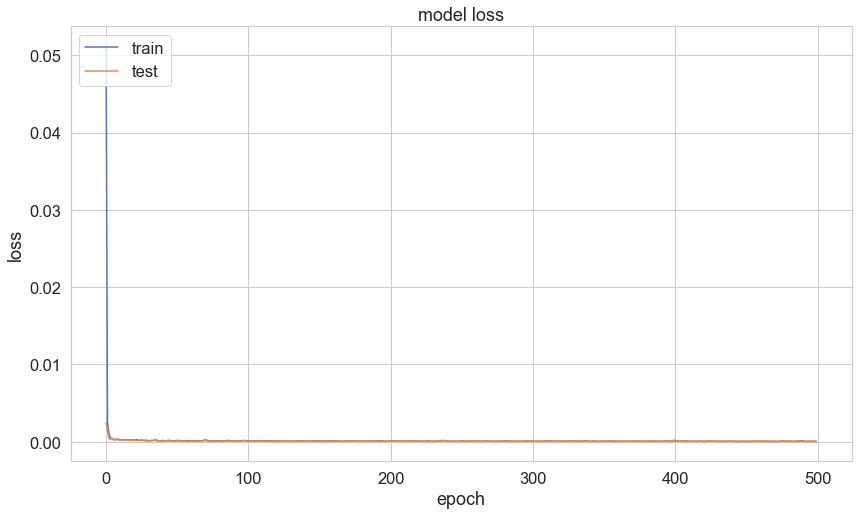

In [223]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

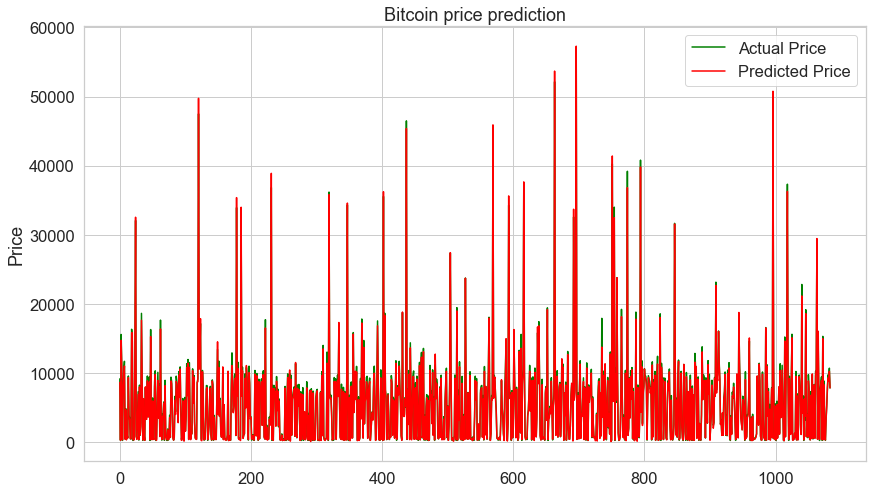

In [224]:
y_hat = model.predict(result['X_train'])

y_test_inverse = result['column_scaler']['close'].inverse_transform(result['y_train'].reshape(-1,1))
y_hat_inverse = result['column_scaler']['close'].inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
# plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

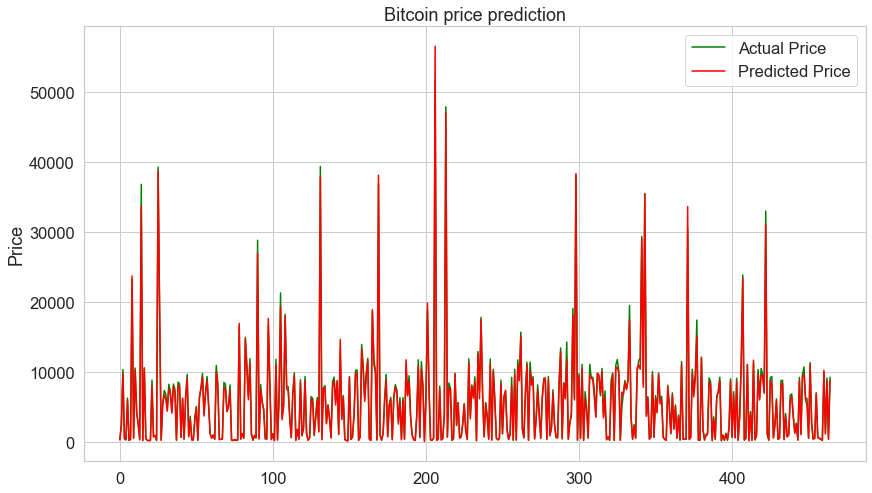

In [225]:
y_hat = model.predict(result['X_test'])

y_test_inverse = result['column_scaler']['close'].inverse_transform(result['y_test'].reshape(-1,1))
y_hat_inverse = result['column_scaler']['close'].inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
# plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [226]:
result['df'].tail(1)

,open,high,low,close,adjclose,volume,ticker,date,open_sp500,high_sp500,...,low_gc,close_gc,adjclose_gc,volume_gc,open_dxy,high_dxy,low_dxy,close_dxy,adjclose_dxy,volume_dxy
date,,,,,,,,,,,,,,,,,,,,,
2021-02-19,51675.980469,56113.652344,50937.277344,55888.132812,55888.132812,6.349550e+10,BTC-USD,2021-02-19,3921.159912,3930.409912,...,1764.300049,1775.800049,1775.800049,587.0,90.57,90.650002,90.18,90.360001,90.360001,0.0


In [227]:
old_df.tail(2)

,open,high,low,close,adjclose,volume,ticker,date,open_sp500,high_sp500,...,low_gc,close_gc,adjclose_gc,volume_gc,open_dxy,high_dxy,low_dxy,close_dxy,adjclose_dxy,volume_dxy
date,,,,,,,,,,,,,,,,,,,,,
2021-02-19,51675.980469,56113.652344,50937.277344,55888.132812,55888.132812,6.349550e+10,BTC-USD,2021-02-19,3921.159912,3930.409912,...,1764.300049,1775.800049,1775.800049,587.0,90.57,90.650002,90.18,90.360001,90.360001,0.0
2021-02-20,55887.335938,57505.226562,54626.558594,56099.519531,56099.519531,6.814546e+10,BTC-USD,2021-02-20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
last_sequence = result["last_sequence"][-WINDOW_SIZE:]
last_sequence = np.expand_dims(last_sequence, axis=0)
prediction = model.predict(last_sequence)

In [229]:
predicted_price = result["column_scaler"]["close"].inverse_transform(prediction)[0][0]
predicted_price

61086.1